In [1]:
import numpy as np
import pandas as pd
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
import cv2
from common import *
from models import *
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from matplotlib import cm as matplot_cm


print(f"Root directory: {os.getcwd()}")
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
#     "font.size": 10,
# })

#%matplotlib

Root directory: c:\Users\andre\Dropbox\FYS-STK4155_projects\FYS-STK4155 - Project2\FYS-STK4155-Prj2_report\code


# Reading data and resizing

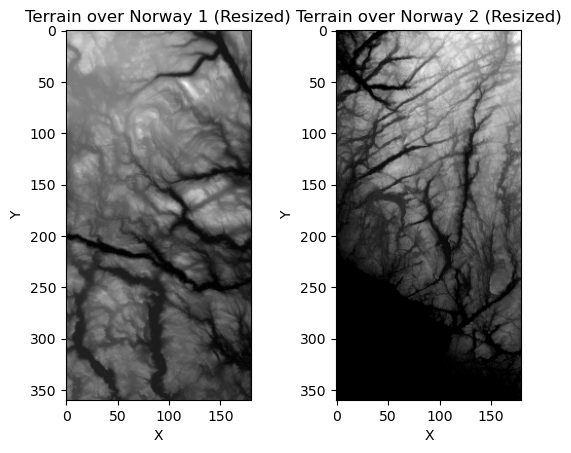

In [2]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Resizing the image
rescale_factor = 0.1
y_size = int(terrain1.shape[0] * rescale_factor)
x_size = int(terrain1.shape[1] * rescale_factor)
terrain1Resized = cv2.resize(terrain1, (x_size, y_size))
terrain2Resized = cv2.resize(terrain2, (x_size, y_size))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')
plt.show()

# Creating image patches and Terrain data selection

In [3]:
nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)
patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)
#fig1 = plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")
#plt.show()
patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)
#fig2 = plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")
#plt.show()

# Choosing two interesting terrain patches
img1 = patches_1[2]
img2 = patches_2[5]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

# Constructing the terrain data
terrain_data = 1
if terrain_data == 1: # Choosing terrain1*
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2
    
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)

60
60


# Best NN vs OLS

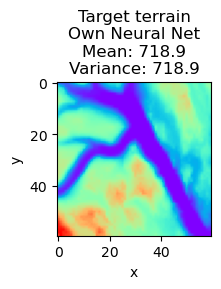

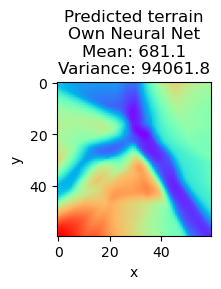

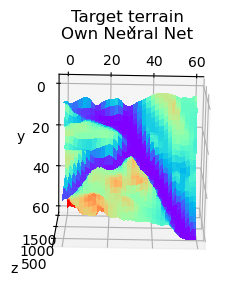

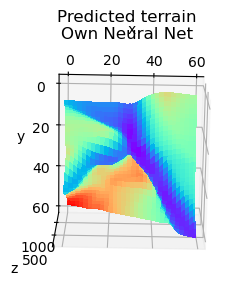

In [4]:
path= "../data/models/the_very_best_model/"
filename = f"{path}best_large_model_leaky_relu_mse_0.108.pkl"
best_model = load_model(filename)

deg = 1
X = create_X(x, y, deg) # Design Matrix 
X = remove_intercept(X)
X_scaled, _ = standard_scaling_single(X)
z_scaled, z_scaler = standard_scaling_single(z.ravel().reshape(-1,1))


z_hat = best_model.predict(X_scaled)
z_hat = z_scaler.inverse_transform(z_hat.reshape(-1,1))
z_hat = z_hat.reshape((y_steps,x_steps))
mean_val = np.round(np.mean(z_hat),decimals=1)
var_val = np.round(np.var(z_hat),decimals=1)


# 2D plot of target terrain 
plt.figure(figsize=(2,2))
plt.imshow(z ,cmap='rainbow')
title = f"Target terrain\nOwn Neural Net\nMean: {np.round(np.mean(z), decimals=1)}\nVariance: {np.round(np.mean(z),decimals=1)}"
plt.title(title)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(f"{path}2d_plot_target.pdf")
plt.show()


# 2D plot of predicted terrain 
plt.figure(figsize=(2,2))
plt.imshow(z_hat ,cmap='rainbow')
title = f"Predicted terrain\nOwn Neural Net\nMean: {mean_val}\nVariance: {var_val}"
plt.title(title)
plt.xlabel("x")
plt.ylabel("y")
plt.savefig(f"{path}2d_plot_predicted.pdf")
plt.show()


# 3D plot of target terrain
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
title = f"Target terrain\nOwn Neural Net"
ax.title.set_text(title)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
#ax2.view_init(elev=60., azim=-120.0-70)
ax.view_init(elev=-75., azim=-91)
# sutf = ax.plot_surface(x, y, z_hat, cmap=matplot_cm.coolwarm, linewidth = 0, antialiased=False)
sutf = ax.plot_surface(x, y, z, cmap="rainbow", linewidth = 0, antialiased=False)
plt.savefig(f"{path}3d_plot-target.pdf")
plt.show()

# 3D plot of predicted terrain
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')
title = f"Predicted terrain\nOwn Neural Net"
ax.title.set_text(title)
ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
#ax2.view_init(elev=60., azim=-120.0-70)
ax.view_init(elev=-75., azim=-91)
# sutf = ax.plot_surface(x, y, z_hat, cmap=matplot_cm.coolwarm, linewidth = 0, antialiased=False)
sutf = ax.plot_surface(x, y, z_hat, cmap="rainbow", linewidth = 0, antialiased=False)
plt.savefig(f"{path}3d_plot-predicted.pdf")
plt.show()

# Parameters VS MSE - Sigmoid function

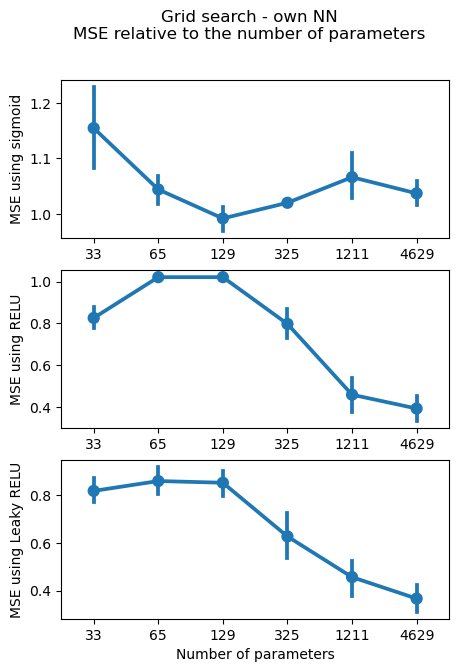

In [30]:
sigmoid_file = f"{REPORT_DATA}PARAMETERS_sigmoid_results.csv"
sigmoid_results = pd.read_csv(sigmoid_file)

relu_file = f"{REPORT_DATA}PARAMETERS_relu_results.csv"
relu_results = pd.read_csv(relu_file)

leaky_relu_file = f"{REPORT_DATA}PARAMETERS_leaky_relu_results.csv"
leaky_relu_results = pd.read_csv(leaky_relu_file)

# Plot
fig, [ax1, ax2, ax3] = plt.subplots(3, figsize=(5,7))
plt.suptitle("Grid search - own NN\nMSE relative to the number of parameters")
sns.pointplot(data=sigmoid_results, x="parameters_own_NN", y="MSE_own_NN", ax=ax1) #categorical plot
sns.pointplot(data=relu_results, x="parameters_own_NN", y="MSE_own_NN", ax=ax2) #categorical plot
sns.pointplot(data=leaky_relu_results, x="parameters_own_NN", y="MSE_own_NN", ax=ax3) #categorical plot
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("Number of parameters")
ax1.set_ylabel("MSE using sigmoid")
ax2.set_ylabel("MSE using RELU")
ax3.set_ylabel("MSE using Leaky RELU")
plt.savefig(f"{REPORT_FIGURES}NN_MSE_vs_Parameters.pdf")
plt.show()

# Our NN vs Tensorflow - Large architecture using Leaky RELU

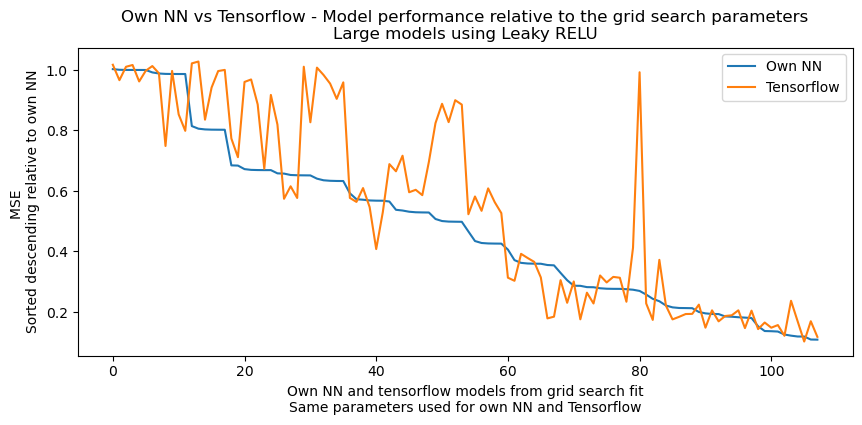

In [53]:
NN_vs_TF_file = f"{REPORT_DATA}NN_vs_TF_large_leaky_relu.csv"
NN_vs_TF_results = pd.read_csv(NN_vs_TF_file)
x = np.arange(NN_vs_TF_results.shape[0])
y_nn = NN_vs_TF_results["MSE_own_NN"].to_numpy()
y_tf = NN_vs_TF_results["MSE_tensorflow"].to_numpy()

plt.figure(figsize=(10,4))
plt.plot(x,y_nn, label=f"Own NN")
plt.plot(x,y_tf, label=f"Tensorflow")
plt.legend()
plt.ylabel("MSE \nSorted descending relative to own NN")
plt.xlabel("Own NN and tensorflow models from grid search fit\nSame parameters used for own NN and Tensorflow")
plt.title("Own NN vs Tensorflow - Model performance relative to the grid search parameters\nLarge models using Leaky RELU")
plt.savefig(f"{REPORT_FIGURES}Own_NN_vs_Tensorflow_Leaky_RELU_Large_architecture.pdf")
plt.show()

